# Redes Complejas 

## Trabajo Práctico 1

In [1]:
# Imports

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_palette('dark')

### `Stanford.adjlist`

In [2]:
stanford = nx.read_adjlist('datos_tp1/StanfordBerkeleyWeb.adjlist',comments='%')

Para hacer este análisis de escala, lo que tenemos que hacer es ir sampleando diferentes subgrafos, de tamaño variable e ir computando los tiempos del betweenness y la proximidad. 

In [3]:
import random
random.seed(42)
nodes = list(stanford.nodes)
random.shuffle(nodes)

In [59]:
sample_size = [5000,10000,20000,30000,40000,41240,50000,60000]

In [60]:
# Muestras aleatorias
random_samples = [stanford.subgraph(nodes[:sample_size[i]]) for i in range(len(sample_size))]

In [61]:
# De las muestras aleatorias, nos quedamos sólo con la máxima componente conectada
connected_samples = []
for sample in random_samples:
    connected_components = list(nx.connected_components(sample))
    connected_components.sort(key=len,reverse=True)
    max_connected_component = connected_components[0]
    connected_samples.append(max_connected_component)

In [67]:
subgrafos = [stanford.subgraph(nodes) for nodes in connected_samples]

In [ ]:
import time

times_betweenness = []
times_closeness = []

betweenness_data = []
closeness_data = []

for i,subgraph in enumerate(subgrafos):
    print("Tamaño de grafo:",len(subgrafos[i]),'nodos')
    print('Calculamos betweenness')
    start = time.time()
    foo = nx.betweenness_centrality(subgraph)
    end = time.time()
    print('Tiempo:',end-start)
    times_betweenness.append(end-start)
    betweenness_data.append(foo)
    
    print('Calculamos proximidad')
    start = time.time()
    foo = nx.closeness_centrality(subgraph)
    end = time.time()
    print('Tiempo:',end-start)
    times_closeness.append(end-start)
    closeness_data.append(foo)
    
print('Listo\n')

In [69]:
# Salvamos datos para no correr todo de nuevo
import pickle
with open('stanford_data/betw_data.data','wb') as open_file:
    pickle.dump(betweenness_data,open_file)
with open('stanford_data/betw_times.data','wb') as open_file:
    pickle.dump(times_betweenness,open_file)
with open('stanford_data/clos_data.data','wb') as open_file:    
    pickle.dump(closeness_data,open_file)
with open('stanford_data/clos_times.data','wb') as open_file:
    pickle.dump(times_closeness,open_file)

Vamos a ajustar sobre los datos de tiempos leyes de potencia tipo

$$ t(N) = t_0 N^\gamma$$

siendo $t$ el tiempo requerido para calcular, y $N$ el tamaño del subgrafo (medido en cantidad de nodos). Los parámetros de ajuste son la constante de proporcionalidad $t_0$ y el exponente $\gamma$.

In [88]:
size_subgrafos = [len(subgrafo) for subgrafo in subgrafos[:-1]]

In [96]:
# Intentemos ajustar una ley de potencia sobre estos datos

def power_law(X,a,gamma):
    return a *(X**gamma)

from scipy.optimize import curve_fit

p0_btw,pcov_btw = curve_fit(power_law,size_subgrafos,times_betweenness)
p0_clo,pcov_clo = curve_fit(power_law,size_subgrafos,times_closeness)

In [97]:
X = np.linspace(40,8500,10000)

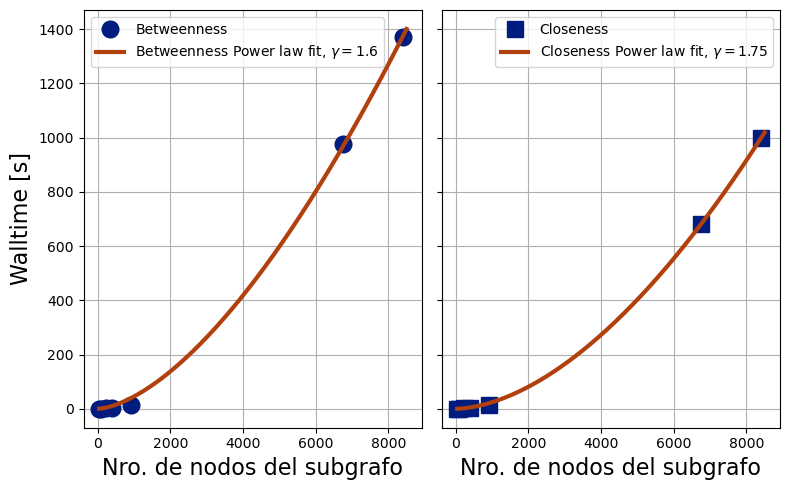

In [114]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,5),sharey=True)

ax1.plot(size_subgrafos,times_betweenness,'o',markersize=12,linewidth=2,label='Betweenness')
ax1.plot(X,power_law(X,*p0_btw),linewidth=3,label='Betweenness Power law fit, $\\gamma=1.6$')

ax2.plot(size_subgrafos,times_closeness,'s',markersize=12,linewidth=2,label='Closeness')
ax2.plot(X,power_law(X,*p0_clo),'-',linewidth=3,label='Closeness Power law fit, $\\gamma=1.75$')

ax1.set_xlabel('Nro. de nodos del subgrafo',size=16)
ax1.set_ylabel('Walltime [s]',size=16)

ax2.set_xlabel('Nro. de nodos del subgrafo',size=16)

ax1.legend()
ax2.legend()

ax1.grid()
ax2.grid()
plt.tight_layout()

In [108]:
degree_data = [nx.degree(subgraph) for subgraph in subgrafos]

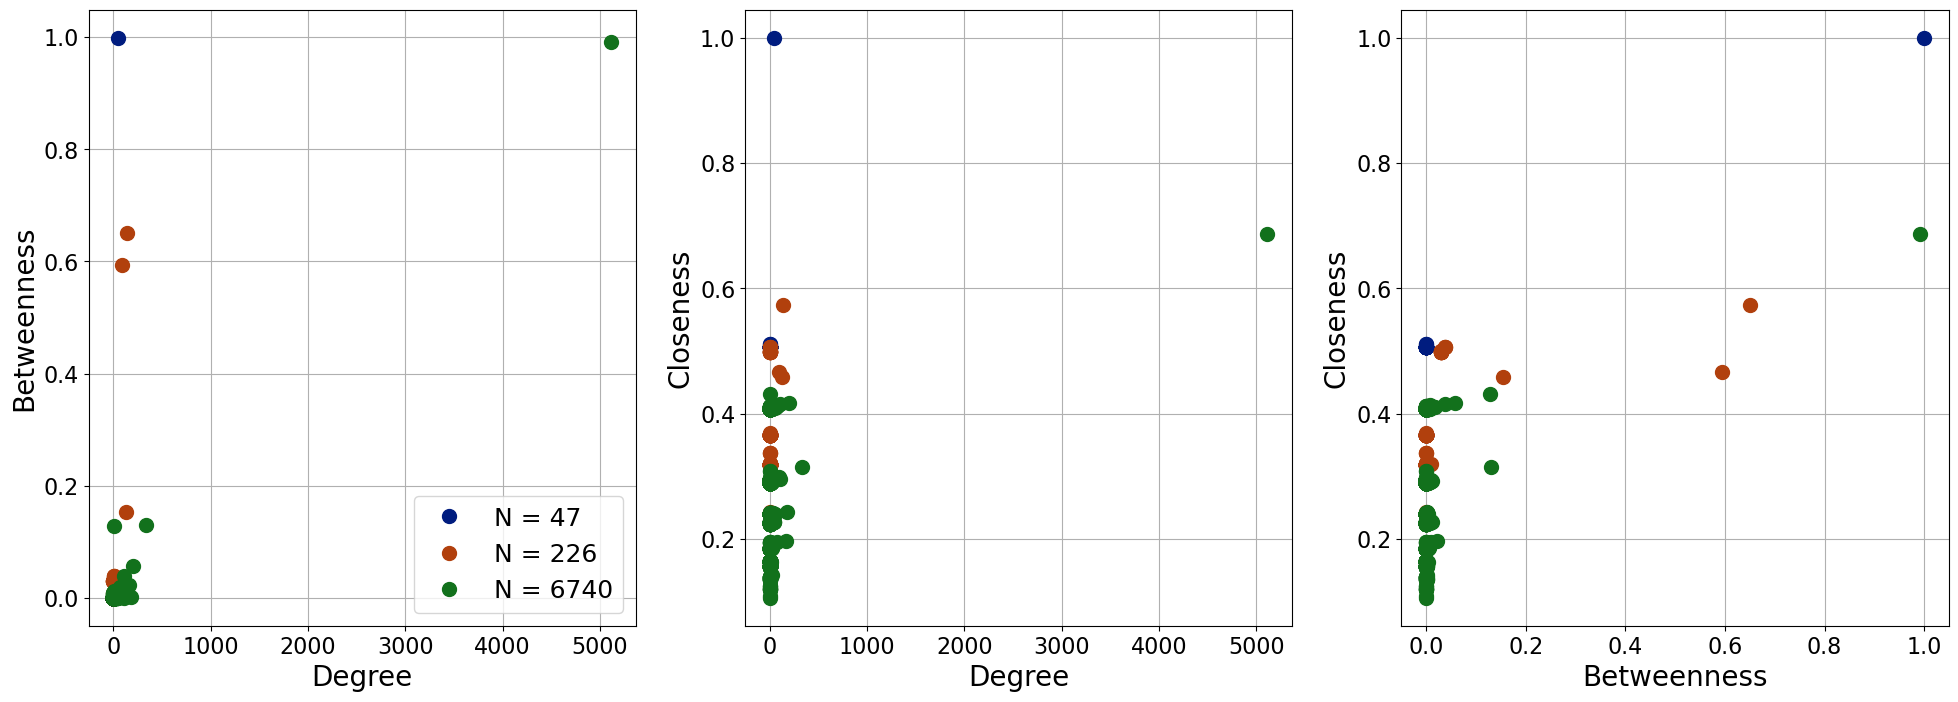

In [110]:
# Correlaciones

fig, axs = plt.subplots(1,3,figsize=(24,8))

idx = [0,2,5]

for i in idx :   
    btw_list = list(betweenness_data[i].values())
    clo_list = list(closeness_data[i].values())
    degree_list = list(dict(degree_data[i]).values())
    
    axs[0].plot(degree_list,btw_list,'o',markersize=10,label=f'N = {size_subgrafos[i]}')
    axs[1].plot(degree_list,clo_list,'o',markersize=10)
    axs[2].plot(btw_list,clo_list,'o',markersize=10)
    
axs[0].set_xlabel('Degree',fontsize=20)
axs[1].set_xlabel('Degree',fontsize=20)
axs[2].set_xlabel('Betweenness',fontsize=20)

axs[0].set_ylabel('Betweenness',fontsize=20)
axs[1].set_ylabel('Closeness',fontsize=20)
axs[2].set_ylabel('Closeness',fontsize=20)

axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=16)

axs[0].legend(fontsize=18)

axs[0].grid()
axs[1].grid()
axs[2].grid()

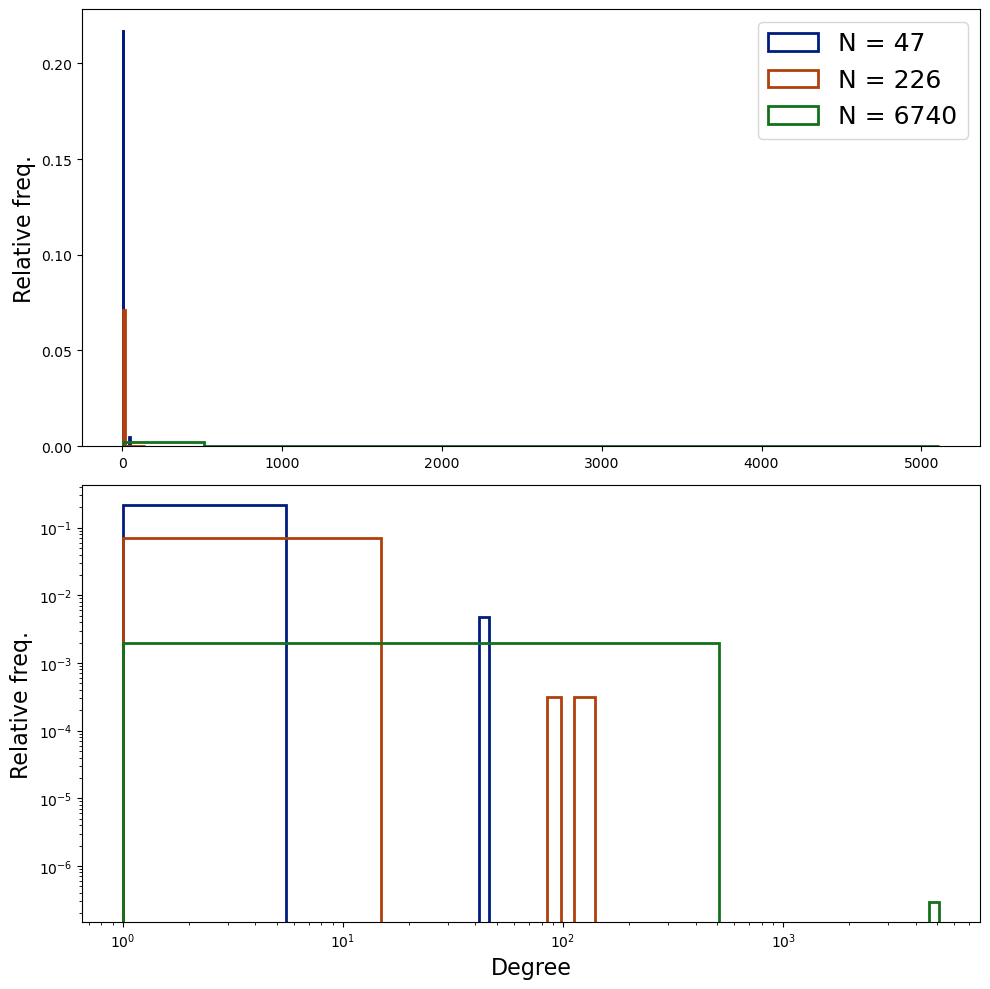

In [116]:
fig,axs = plt.subplots(2,1,figsize=(10,10))

idx = [0,2,5]

for i in idx:
    degree_list = list(dict(degree_data[i]).values())
    
    axs[0].hist(degree_list,density=True,histtype='step',linewidth=2,label=f'N = {size_subgrafos[i]}')
    axs[1].hist(degree_list,density=True,histtype='step',linewidth=2)

axs[1].set_yscale('log')
axs[1].set_xscale('log')

axs[0].legend(fontsize=18)

axs[1].set_xlabel('Degree',fontsize=16)
axs[0].set_ylabel('Relative freq.',fontsize=16)
axs[1].set_ylabel('Relative freq.',fontsize=16)

plt.tight_layout()